# Código para Unir los datasets

## Instalar Librerías

In [ ]:
#instala pandas
%pip install pandas

## Primer modelo
Cantidad de datos: 166475

In [ ]:
import pandas as pd
import numpy as np
from urllib.parse import urlparse
import datetime as datetime

# Enlaces de tus archivos
url_discapacidad = 'https://drive.google.com/file/d/1k5tO-1iZ5FGWMJuykYylvbyafiXIMnZ-/view?usp=drive_link'
url_educacion = 'https://drive.google.com/file/d/1RBDPcDPG2mCV6dQbUlEJYy8KpnuDPAJH/view?usp=drive_link'
url_postulante = 'https://drive.google.com/file/d/1SafIdXKzpLRDJrCQuMAyJh-vE84Zv-P8/view?usp=drive_link'

# Función para convertir el enlace de Google Drive en enlace directo
def get_drive_link(url):
    file_id = url.split('/')[-2]
    return f'https://drive.google.com/uc?id={file_id}'

# 1. Leer los archivos
try:
    # Leer postulante
    df_postulante = pd.read_csv(get_drive_link(url_postulante))
    print("Archivo de postulante leído correctamente")

    # Leer educación
    df_educacion = pd.read_csv(get_drive_link(url_educacion),
                              sep=';',
                              quotechar='"',
                              encoding='utf-8',
                              engine='c',
                              on_bad_lines='skip')
    print("Archivo de educación leído correctamente")

    # Leer discapacidad
    df_discapacidad = pd.read_csv(get_drive_link(url_discapacidad))
    print("Archivo de discapacidad leído correctamente")

    #Leer DATA_EXPERIENCIASLABORALES
    df = pd.read_csv('DATA_EXPERIENCIASLABORALES.csv', sep=',')
    #Quitar Saltos de linea en descripción
    df['DESCRIPCION'] = df['DESCRIPCION'].str.replace('\n', ' ')

    # 2. Unir los DataFrames
    # Primero unimos postulante con educación
    df_merged = pd.merge(df_postulante,
                        df_educacion,
                        on='ID_POSTULANTE',
                        how='left')

    # Luego unimos con discapacidad (asegurándonos que las columnas coincidan)
    # Renombrar la columna en discapacidad si es necesario
    if 'DBIDPOSTULANTE' in df_discapacidad.columns:
        df_discapacidad = df_discapacidad.rename(columns={'DBIDPOSTULANTE': 'DOC_ID'})

    df_final = pd.merge(df_merged,
                       df_discapacidad,
                       on='DOC_ID',
                       how='left')
    
    #Unir con DATA_EXPERIENCIASLABORALES
    df_final = pd.merge(df_final,
                       df,
                       on='ID_POSTULANTE',
                       how='left')

    # 3. Limpieza básica
    # Rellenar valores nulos en columnas categóricas y numéricas
    categorical_columns = ['GRADO', 'CARRERA', 'INSTITUCION', 'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO']
    for col in categorical_columns:
        df_final[col] = df_final[col].fillna('No especificado')

    numeric_columns = ['ESTADO_CONADIS', 'DSCORE']
    for col in numeric_columns:
        df_final[col] = df_final[col].fillna(0)

    # Rellenar valores nulos específicos para otras columnas
    df_final['EDAD'] = df_final['EDAD'].fillna(df_final['EDAD'].median())  # Usar la mediana para edad
    df_final['SEXO'] = df_final['SEXO'].fillna('No especificado')
    df_final['UBIGEO'] = df_final['UBIGEO'].fillna('No especificado')
    df_final['DOC_ID'] = df_final['DOC_ID'].fillna('No especificado')
    df_final['CAUSA'] = df_final['CAUSA'].fillna('No especificado')

    # Rellenar valores nulos en fechas con un valor estándar o marcador de "no especificado"
    df_final['FECHAINICIO_x'] = df_final['FECHAINICIO_x'].fillna('No especificado')
    df_final['FECHAFIN_x'] = df_final['FECHAFIN_x'].fillna('No especificado')
    df_final['FECHAINICIO_y'] = df_final['FECHAINICIO_y'].fillna('No especificado')
    df_final['FECHAFIN_y'] = df_final['FECHAFIN_y'].fillna('No especificado')

    # Rellenar valores nulos en campos de texto y rangos salariales
    df_final['EMPRESA'] = df_final['EMPRESA'].fillna('No especificado')
    df_final['DESCRIPCION'] = df_final['DESCRIPCION'].fillna('No especificado')
    df_final['RANGO_SALARIAL'] = df_final['RANGO_SALARIAL'].fillna('No especificado')


    # 4. Guardar el resultado
    df_final.to_csv('datos_unidos.csv', index=False, encoding='utf-8')
    print("\nArchivo guardado exitosamente como 'datos_unidos.csv'")

    # 5. Crear otro DataFrame con solo las personas que tengan experiencia laboral
    df_experiencia = df_final[df_final['EMPRESA'] != 'No especificado']
    df_experiencia.to_csv('datos_experiencia.csv', index=False, encoding='utf-8')
    print("\nArchivo guardado exitosamente como 'datos_experiencia.csv'")

    # 5. Mostrar resumen de ambos DataFrames
    print("\nResumen de datos unidos:")
    print(df_final.info())
    print("\nResumen de datos con experiencia laboral:")
    print(df_experiencia.info())

    #imprimir 5 regisateos de cada uno
    print("\n5 primeros registros de datos unidos:")
    print(df_final.head())
    print("\n5 primeros registros de datos con experiencia laboral:")
    print(df_experiencia.head())


except Exception as e:
    print("Error en el proceso:", e)


Archivo de postulante leído correctamente
Archivo de educación leído correctamente
Archivo de discapacidad leído correctamente

Archivo guardado exitosamente como 'datos_unidos.csv'
Error en el proceso: ['ID_EXPERIENCIALABORAL']


# TRATAMIENTO DE DATOS

### DATASET: EXPERIENCIAS LABORALES

- **ID_POSTULANTE**: Código o llave para relacionarlo con el archivo de `DATA_POSTULANTE`. ID del postulante anonimizado.

- **EMPRESA**: Nombre de la empresa donde laboró el postulante. Anonimizado.

- **FECHAINICIO_EXP**: Fecha de inicio de la relación laboral.

- **FECHAFIN_EXP**: Fecha de finalización de la relación laboral.

- **DESCRIPCION**: Descripción detallada de la experiencia laboral del postulante.

- **RANGO_SALARIAL**: Rango salarial durante el periodo laboral en la empresa.

In [27]:
import re

df = pd.read_csv('DATA_EXPERIENCIASLABORALES.csv', sep=',')

#Pasar a formato fecha FECHAINICIO y FECHAFIN en el formato YYYYMMDD
df['FECHAINICIO'] = pd.to_datetime(df['FECHAINICIO'], format='%Y%m%d', errors='coerce')
df['FECHAFIN'] = pd.to_datetime(df['FECHAFIN'], format='%Y%m%d', errors='coerce')

#Llenar valores nulos en FECHAFIN y FECHAINICIO
df['FECHAINICIO'] = df['FECHAINICIO'].fillna('No especificado')
df['FECHAFIN'] = df['FECHAFIN'].fillna('No especificado')

#Cambiar el nombre de las columnas FECHAINICIO y FECHAFIN, por FECHAINICIO_EXP y FECHAFIN_EXP
df = df.rename(columns={'FECHAINICIO': 'FECHAINICIO_EXP', 'FECHAFIN': 'FECHAFIN_EXP'})

# Función de limpieza para aplicar a cada texto en la columna DESCRIPCION
def limpiar_descripcion(texto):
    # 1. Normalizar caracteres especiales comunes
    replacements = {
        'Ã¡': 'á', 'Ã©': 'é', 'Ã­': 'í', 'Ã³': 'ó', 'Ãº': 'ú',
        'Ã‘': 'Ñ', 'Ã±': 'ñ', 'Ã¼': 'ü', 'Â¿': '¿', 'Â¡': '¡',
        'Â': '', 'Ä': 'A', 'Å': 'A', 'Æ': 'E', 'Ç': 'C', 'Ã':'o',
        # Añade otros caracteres especiales según sea necesario
    }
    
    for key, value in replacements.items():
        texto = texto.replace(key, value)

    # 2. Remover todas las comillas dobles, comillas simples y comas
    texto = re.sub(r'[“”"‘’\',]', '', texto)
    
    # 3. Eliminar saltos de línea, tabulaciones y caracteres extraños
    texto = re.sub(r'[\r\n\t]+', ' ', texto)
    
    # 4. Quitar emojis y caracteres no deseados específicos
    texto = re.sub(r'[^\w\s.%€$]', '', texto)

    # Borra especificamente este caracter â€
    texto = texto.replace('â€', '')
    
    # 5. Remover guiones y espacios redundantes
    texto = re.sub(r'[-]+', ' ', texto)
    
    # 6. Convertir a texto plano y quitar espacios extra
    texto = re.sub(r'\s+', ' ', texto).strip()
    
    # 7. Normalizar acentos y caracteres especiales manualmente
    replacements = {
        'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u',
        'Á': 'A', 'É': 'E', 'Í': 'I', 'Ó': 'O', 'Ú': 'U',
        'ñ': 'n', 'Ñ': 'N', '¿': '', '¡': '', 'ü': 'u', 'ç': 'c', 'Ãœ': 'u'
    }
    for key, value in replacements.items():
        texto = texto.replace(key, value)

    return texto

# Aplicar la función de limpieza a la columna DESCRIPCION
df['DESCRIPCION'] = df['DESCRIPCION'].apply(limpiar_descripcion)

# Llenar valores nulos en DESCRIPCION
df['DESCRIPCION'] = df['DESCRIPCION'].str.replace('nan', 'No especificado')
df['DESCRIPCION'] = df['DESCRIPCION'].fillna('No especificado')

# Rellenar valores nulos en EMPRESA
df['EMPRESA'] = df['EMPRESA'].fillna('No especificado') 

#Tratar columna RANGO_SALARIAL
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('Hasta-', '0 - ')
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('Hasta - ', '0 - ')
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('Hasta ', '0 - ')
#tratar para casos como >=10000 y similares
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('>=', '0 - ')
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('>', '')
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('=', '')
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace(' ', '')
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('A', '-')
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('a', '-')
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('AL', '-')
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('al', '-')
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('DE', '-')
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('de', '-')
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('Y', '-')
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('y', '-')
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('HASTA', '-')
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].str.replace('hasta', '-')
#Llenar valores nulos en RANGO_SALARIAL
df['RANGO_SALARIAL'] = df['RANGO_SALARIAL'].fillna('No especificado')
#Divide esta columna en dos columnas SALARIO_MIN y SALARIO_MAX, si existe un solo valor se duplica
df[['SALARIO_MIN', 'SALARIO_MAX']] = df['RANGO_SALARIAL'].str.split('-', expand=True)
#Convierte los valores a numéricos
df['SALARIO_MIN'] = pd.to_numeric(df['SALARIO_MIN'], errors='coerce')
df['SALARIO_MAX'] = pd.to_numeric(df['SALARIO_MAX'], errors='coerce')
#Rellenar valores nulos
df['SALARIO_MIN'] = df['SALARIO_MIN'].fillna(0)
df['SALARIO_MAX'] = df['SALARIO_MAX'].fillna(0)

#imprimir todos los nulos o NaN o estén vacios por columna de data_experoenciaslaborales
print("\nNulos en DATA_EXPERIENCIASLABORALES:")
print(df.isnull().sum())

#Guardar el archivo limpio
df.to_csv('EXPERIENCIASLABORALES_NOT_NULL.csv', index=False, encoding='utf-8')
print("\nArchivo guardado exitosamente como 'EXPERIENCIASLABORALES_NOT_NULL.csv'")

df.head()


Nulos en DATA_EXPERIENCIASLABORALES:
ID_POSTULANTE      0
EMPRESA            0
FECHAINICIO_EXP    0
FECHAFIN_EXP       0
DESCRIPCION        0
RANGO_SALARIAL     0
SALARIO_MIN        0
SALARIO_MAX        0
dtype: int64

Archivo guardado exitosamente como 'EXPERIENCIASLABORALES_NOT_NULL.csv'


,ID_POSTULANTE,EMPRESA,FECHAINICIO_EXP,FECHAFIN_EXP,DESCRIPCION,RANGO_SALARIAL,SALARIO_MIN,SALARIO_MAX
0,03AFDBD66E7929B125F8597834FA83A4,AAB3DD1AA8AF62CB516EE8C9AEEB0B35,2020-03-01 00:00:00,2021-07-01 00:00:00,capacitar a miembros de mesa fuerzas armadas y...,2500-2999,2500.0,2999.0
1,03AFDBD66E7929B125F8597834FA83A4,AAB3DD1AA8AF62CB516EE8C9AEEB0B35,2020-03-01 00:00:00,2021-07-01 00:00:00,capacitar a miembros de mesa fuerzas armadas y...,2500-2999,2500.0,2999.0
2,EA5D2F1C4608232E07D3AA3D998E5135,89C9A87CE323B6A3086D15356D3DB2BA,2019-06-01 00:00:00,2020-09-01 00:00:00,Valorizacion de los trabajos realizados mensua...,1600-1799,1600.0,1799.0
3,EA5D2F1C4608232E07D3AA3D998E5135,89C9A87CE323B6A3086D15356D3DB2BA,2019-06-01 00:00:00,2020-09-01 00:00:00,Valorizacion de los trabajos realizados mensua...,1600-1799,1600.0,1799.0
4,FC490CA45C00B1249BBE3554A4FDF6FB,8EAC8447385B013E2A83BAAAB6B47F35,2003-10-01 00:00:00,2021-01-01 00:00:00,jefe de division jefe de ventas jefe de almacen,2500-2999,2500.0,2999.0


### DATASET: POSTULANTE

- **ID_POSTULANTE**: Código o llave para relacionarlo con el archivo de `DATA_EDUCACION` y `DATA_EXPERIENCIASLABORALES`. ID del postulante anonimizado.

- **EDAD**: Edad del postulante.

- **SEXO**: Sexo del postulante.  
  - `F` = Femenino  
  - `M` = Masculino

- **DEPARTAMENTO**: Departamento donde vive el postulante.

- **PROVINCIA**: Provincia donde vive el postulante.

- **DISTRITO**: Distrito donde vive el postulante.

- **UBIGEO**: Código de ubicación geográfica donde vive el postulante.

- **ESTADO_CONADIS**: Inscrito en CONADIS.  
  - `1` = Sí, está inscrito  
  - `0` = No está inscrito

- **DOC_ID**: Código o llave para relacionarlo con el archivo de `DATA_DISCAPACIDAD`.

In [7]:
import pandas as pd
import numpy as np

# Enlaces de tus archivos
url_postulante = 'https://drive.google.com/file/d/1SafIdXKzpLRDJrCQuMAyJh-vE84Zv-P8/view?usp=drive_link'

# Función para convertir el enlace de Google Drive en enlace directo
def get_drive_link(url):
    file_id = url.split('/')[-2]
    return f'https://drive.google.com/uc?id={file_id}'

# 1. Leer los archivos
df_postulante = pd.read_csv(get_drive_link(url_postulante))
print("Archivo de postulante leído correctamente")

#Tratamiento profundo de datos
categorical_columns = ['DEPARTAMENTO', 'PROVINCIA', 'DISTRITO']
for col in categorical_columns:
    df_postulante[col] = df_postulante[col].fillna('No especificado')

# Columna Estado_coanadis es de tipo categorico numerico, llena los valores nulos
df_postulante['ESTADO_CONADIS'] = df_postulante['ESTADO_CONADIS'].fillna(0)

#Rellenar valores nulos específicos para otras columnas
df_postulante['UBIGEO'] = df_postulante['UBIGEO'].fillna('No especificado')

#Imprimir
df_postulante.head()

#Guardar en un nuevo archivo
df_postulante.to_csv('POSTULANTE_NOT_NULL.csv', index=False, encoding='utf-8')
print("\nArchivo guardado exitosamente como 'POSTULANTE_NOT_NULL.csv'")



Archivo de postulante leído correctamente

Archivo guardado exitosamente como 'POSTULANTE_NOT_NULL.csv'


### DATASET: DISCAPACIDAD

- **DOC_ID**: ID del postulante, llave foránea para unir este dataset con el dataset de `POSTULANTES`.

- **CAUSA**: Causa de la discapacidad del postulante.

- **DSCORE**: Nivel de dificultad asociado a la discapacidad.  
  - `1` = Sin dificultad  
  - `2` = Dificultad leve o moderada  
  - `3` = Dificultad severa

In [32]:
url_discapacidad = 'https://drive.google.com/file/d/1k5tO-1iZ5FGWMJuykYylvbyafiXIMnZ-/view?usp=drive_link'

# Función para convertir el enlace de Google Drive en enlace directo
def get_drive_link(url):
    file_id = url.split('/')[-2]
    return f'https://drive.google.com/uc?id={file_id}'

# Leer discapacidad
df_discapacidad = pd.read_csv(get_drive_link(url_discapacidad))
print("Archivo de discapacidad leído correctamente")

#Cantidad de nulos por columna
print("\nNulos en DISCAPACIDAD:")
print(df_discapacidad.isnull().sum())

#Imprime todos los valores de la columna CAUSA
print("\nValores únicos en CAUSA:")
print(df_discapacidad['CAUSA'].unique())

#Imprimir valores unicos de la columna DSCORE
print("\nValores únicos en DSCORE:")
print(df_discapacidad['DSCORE'].unique())

#Cambiar nombre de la columna DBIDPOSTULANTE por DOC_ID
df_discapacidad = df_discapacidad.rename(columns={'DBIDPOSTULANTE': 'DOC_ID'})

#Guardar en un nuevo archivo
df_discapacidad.to_csv('DISCAPACIDAD_NOT_NULL.csv', index=False, encoding='utf-8')
print("\nArchivo guardado exitosamente como 'DISCAPACIDAD_NOT_NULL.csv'")

df_discapacidad.head()

Archivo de discapacidad leído correctamente

Nulos en DISCAPACIDAD:
DBIDPOSTULANTE    0
CAUSA             0
DSCORE            0
dtype: int64

Valores únicos en CAUSA:
['Congénita' 'Adquirida - Edad adulta' 'Adquirida - Niñez'
 'Adquirida - Infancia' 'Adquirida - Juventud']

Valores únicos en DSCORE:
[1 2 3]

Archivo guardado exitosamente como 'DISCAPACIDAD_NOT_NULL.csv'


,DOC_ID,CAUSA,DSCORE
0,000b6cfd5fd843ac94feaf832cf51149,Congénita,1
1,000b6cfd5fd843ac94feaf832cf51149,Congénita,1
2,000b6cfd5fd843ac94feaf832cf51149,Congénita,1
3,000b6cfd5fd843ac94feaf832cf51149,Congénita,1
4,000b6cfd5fd843ac94feaf832cf51149,Congénita,1


### DATASET: EDUCACION

- **ID_POSTULANTE**: Código o llave para relacionarlo con el archivo de `DATA_POSTULANTE`.

- **INSTITUCION**: Institución donde el postulante realizó sus estudios.

- **GRADO**: Grado académico obtenido por el postulante.

- **FECHAINICIO_EDU**: Fecha de inicio de los estudios.

- **FECHAFIN_EDU**: Fecha de finalización de los estudios.

- **CARRERA**: Carrera o especialidad estudiada por el postulante.

In [9]:
import re
import pandas as pd 

# Enlaces de tus archivos
url_educacion = 'https://drive.google.com/file/d/1RBDPcDPG2mCV6dQbUlEJYy8KpnuDPAJH/view?usp=drive_link'

# Función para convertir el enlace de Google Drive en enlace directo
def get_drive_link(url):
    file_id = url.split('/')[-2]
    return f'https://drive.google.com/uc?id={file_id}'

# Leer educación
df_educacion = pd.read_csv(get_drive_link(url_educacion),
                            sep=';',
                            quotechar='"',
                            encoding='utf-8',
                            engine='c',
                            on_bad_lines='skip')
print("Archivo de educación leído correctamente")

#Convertir columna INSTITUCION a String
df_educacion['INSTITUCION'] = df_educacion['INSTITUCION'].astype(str)

# Función de limpieza para aplicar a cada texto en la columna DESCRIPCION
def limpiar_institucion(texto):
    
    # 1. Normalizar caracteres especiales comunes
    replacements = {
        'Ã¡': 'á', 'Ã©': 'é', 'Ã­': 'í', 'Ã³': 'ó', 'Ãº': 'ú',
        'Ã‘': 'Ñ', 'Ã±': 'ñ', 'Ã¼': 'ü', 'Â¿': '¿', 'Â¡': '¡',
        'Â': '', 'Ä': 'A', 'Å': 'A', 'Æ': 'E', 'Ç': 'C', 'Ã':'o',
        # Añade otros caracteres especiales según sea necesario
    }
    
    for key, value in replacements.items():
        texto = texto.replace(key, value)

    # 2. Remover todas las comillas dobles, comillas simples y comas
    texto = re.sub(r'[“”"‘’\',]', '', texto)
    
    # 3. Eliminar saltos de línea, tabulaciones y caracteres extraños
    texto = re.sub(r'[\r\n\t]+', ' ', texto)
    
    # 4. Quitar emojis y caracteres no deseados específicos
    texto = re.sub(r'[^\w\s.%€$]', '', texto)

    # Borra especificamente este caracter â€
    texto = texto.replace('â€', '')
    
    # 5. Remover guiones y espacios redundantes
    texto = re.sub(r'[-]+', ' ', texto)
    
    # 6. Convertir a texto plano y quitar espacios extra
    texto = re.sub(r'\s+', ' ', texto).strip()
    
    # 7. Normalizar acentos y caracteres especiales manualmente
    replacements = {
        'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u',
        'Á': 'A', 'É': 'E', 'Í': 'I', 'Ó': 'O', 'Ú': 'U',
        'ñ': 'n', 'Ñ': 'N', '¿': '', '¡': '', 'ü': 'u', 'ç': 'c', 'Ãœ': 'u'
    }
    for key, value in replacements.items():
        texto = texto.replace(key, value)

    return texto

# Aplicar la función de limpieza a la columna INSTITUCION
df_educacion['INSTITUCION'] = df_educacion['INSTITUCION'].apply(limpiar_institucion)

#Tratamiento de Nulos
categorical_columns = ['GRADO', 'CARRERA', 'INSTITUCION']
for col in categorical_columns:
    df_educacion[col] = df_educacion[col].fillna('No especificado')

#Convertir a fecha las columnas FECHAINICIO y FECHAFIN, el formato es YYYYMMDD
df_educacion['FECHAINICIO'] = pd.to_datetime(df_educacion['FECHAINICIO'], format='%Y%m%d', errors='coerce')
df_educacion['FECHAFIN'] = pd.to_datetime(df_educacion['FECHAFIN'], format='%Y%m%d', errors='coerce')

#Llenar valores nulos en FECHAFIN y FECHAINICIO con valores datetime que no afecten analisis posteriores
df_educacion['FECHAINICIO'] = df_educacion['FECHAINICIO'].fillna(pd.Timestamp('19000101'))
df_educacion['FECHAFIN'] = df_educacion['FECHAFIN'].fillna(pd.Timestamp('19000101'))

#Cambiar nombre de las columnas FECHAINICIO y FECHAFIN por FECHAINICIO_EDU y FECHAFIN_EDU
df_educacion = df_educacion.rename(columns={'FECHAINICIO': 'FECHAINICIO_EDU', 'FECHAFIN': 'FECHAFIN_EDU'})

#Nulos por columna
print("\nNulos en EDUCACIÓN:")
print(df_educacion.isnull().sum())

#Imprimir 5 primeros registros
df_educacion.head()

#Guardar en un nuevo archivo
df_educacion.to_csv('EDUCACION_NOT_NULL.csv', index=False, encoding='utf-8')
print("\nArchivo guardado exitosamente como 'EDUCACION_NOT_NULL.csv'")

Archivo de educación leído correctamente

Nulos en EDUCACIÓN:
ID_POSTULANTE      0
INSTITUCION        0
GRADO              0
FECHAINICIO_EDU    0
FECHAFIN_EDU       0
CARRERA            0
dtype: int64

Archivo guardado exitosamente como 'EDUCACION_NOT_NULL.csv'


# ANÁLISIS DE DATOS POR DATAFRAME

### DATASET: EXPERIENCIAS LABORALES

In [ ]:
%pip install pandas numpy datetime matplotlib seaborn

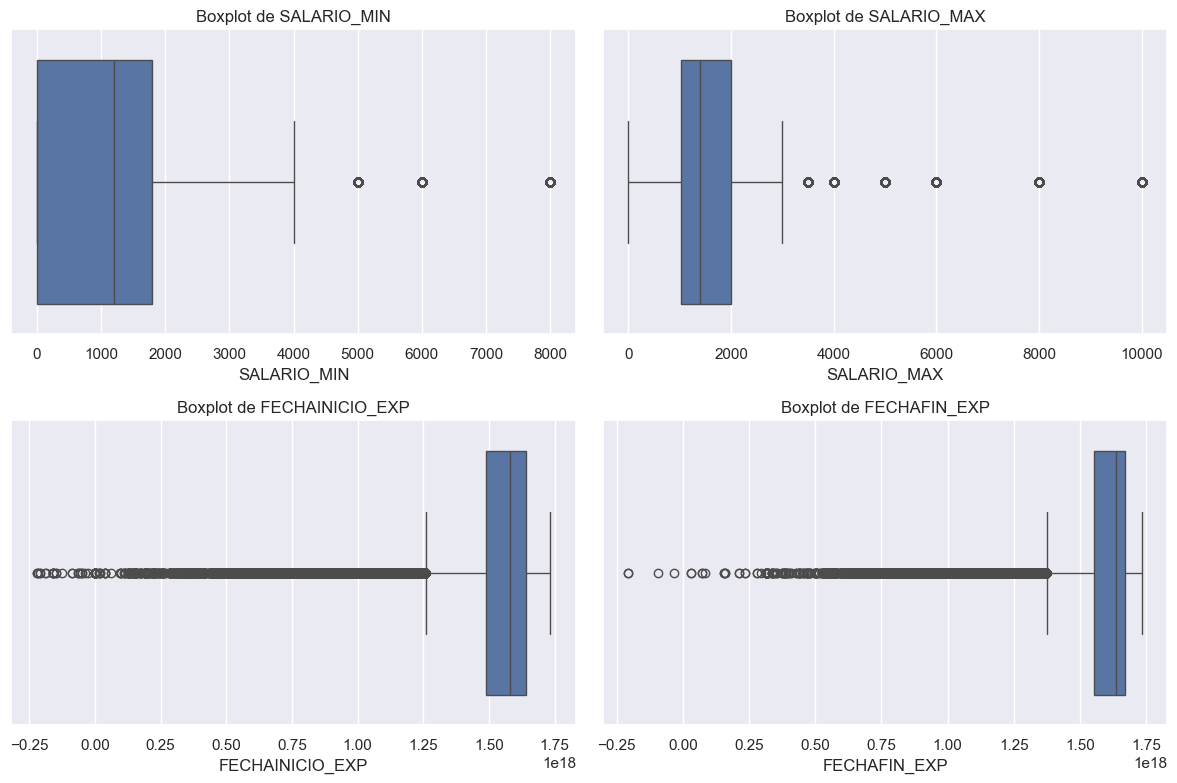


Total de registros: 396969
Salario promedio: 1728.86

Duración promedio de las experiencias laborales (en meses): 20.50


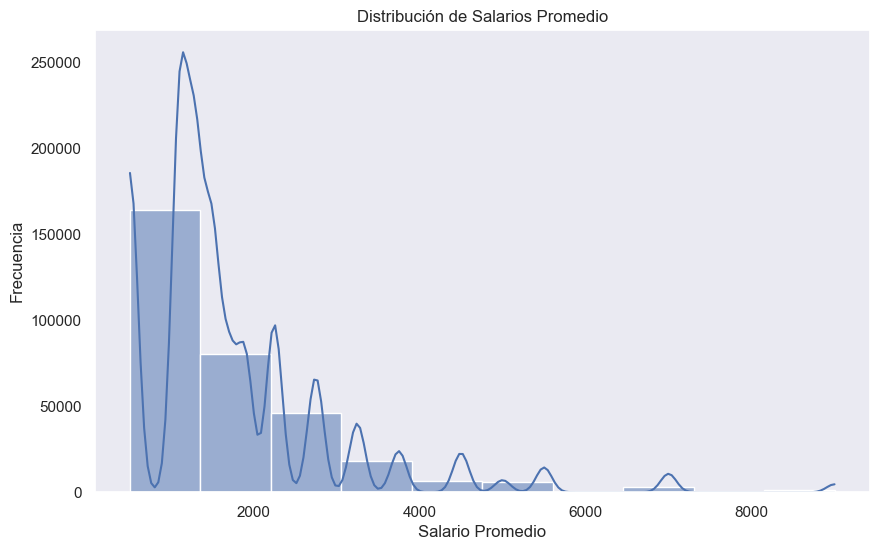

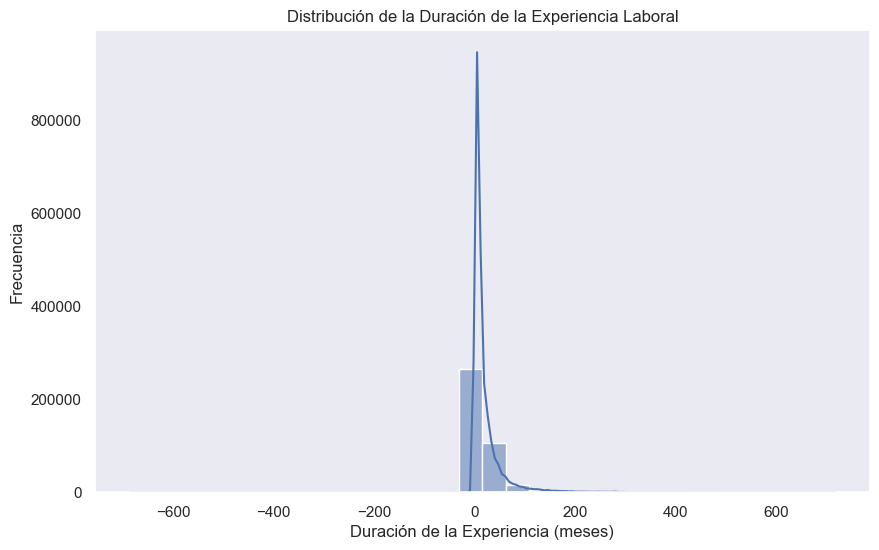

C:\Users\jacia\AppData\Local\Temp\ipykernel_11052\1600956649.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=empresas_mas_postulantes.index, y=empresas_mas_postulantes.values, palette='viridis')


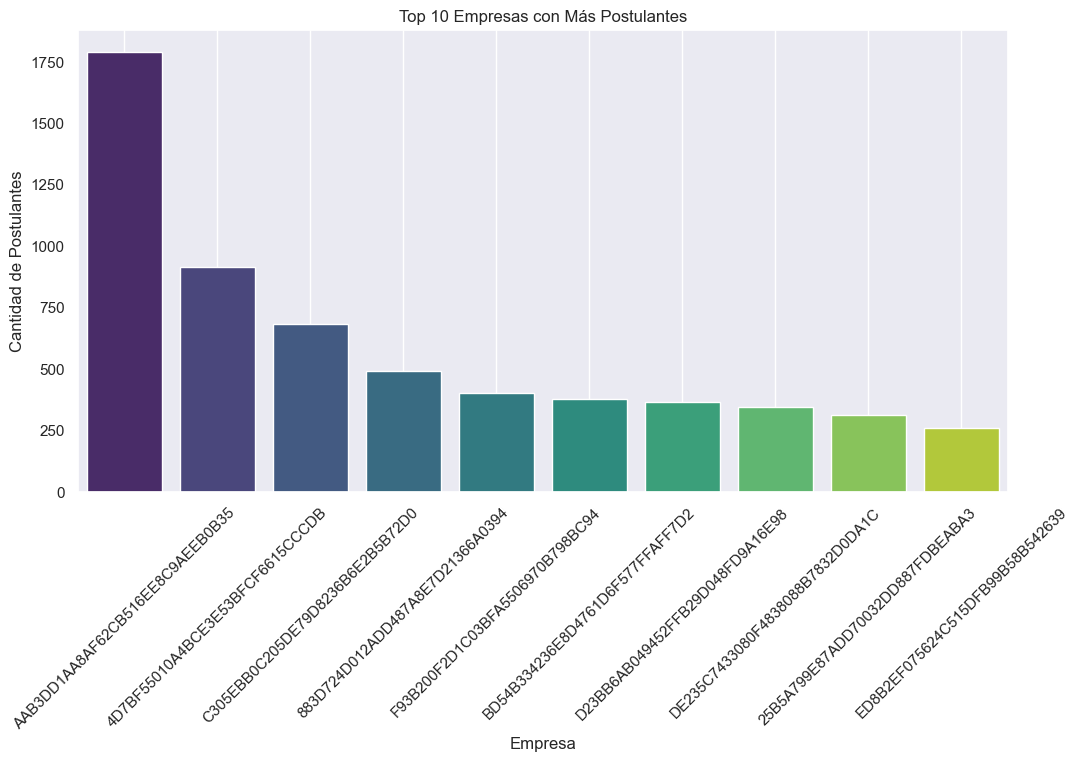

C:\Users\jacia\AppData\Local\Temp\ipykernel_11052\1600956649.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=salario_por_empresa.index, y=salario_por_empresa.values, palette='magma')


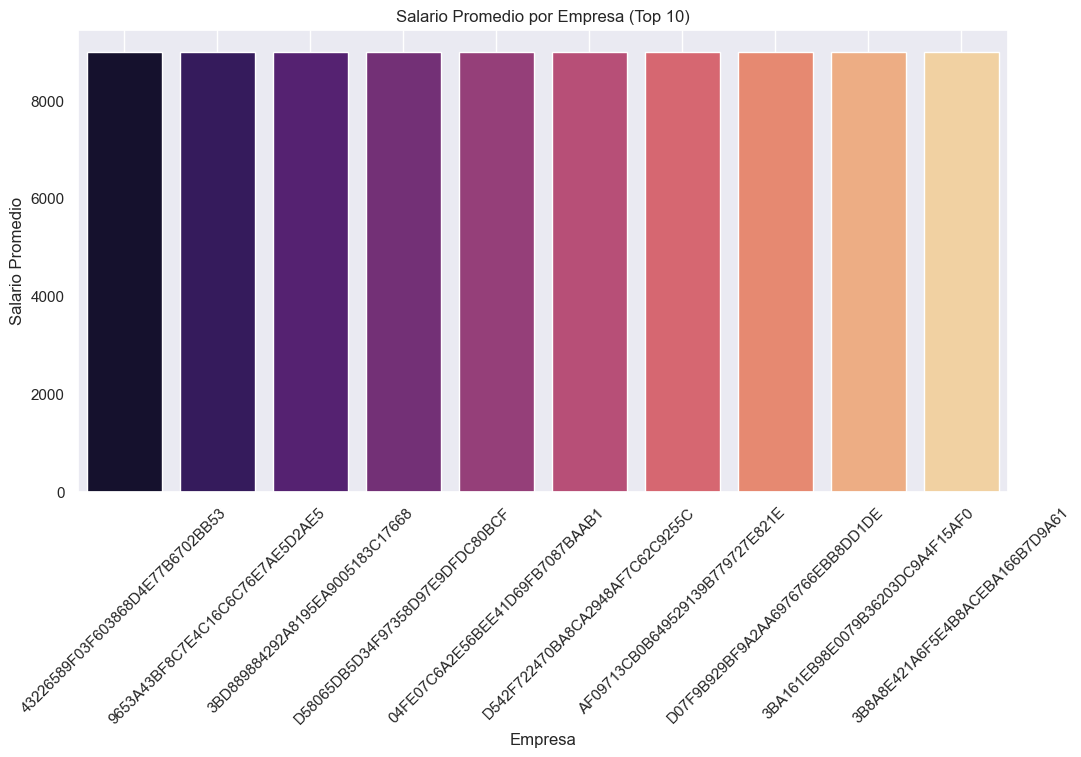

C:\Users\jacia\AppData\Local\Temp\ipykernel_11052\1600956649.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=duracion_por_empresa.index, y=duracion_por_empresa.values, palette='coolwarm')


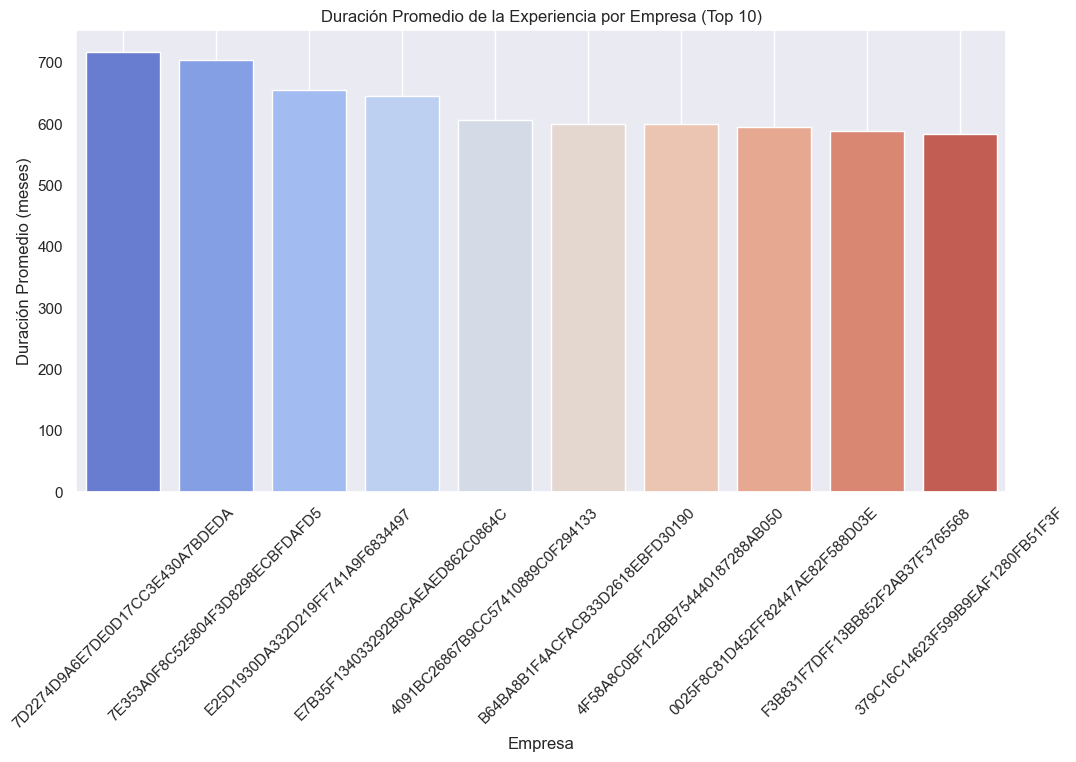


Los 5 salarios mínimos diferentes más bajos:
[1025. 1200. 1400. 1600. 1800.]

Los 10 salarios diferentes más altos:
[ 4999.  5999.  7999.  9999. 10000.]


C:\Users\jacia\AppData\Local\Temp\ipykernel_11052\1600956649.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=salarios_minimos[:5], y=salarios_minimos[:5], palette='viridis')


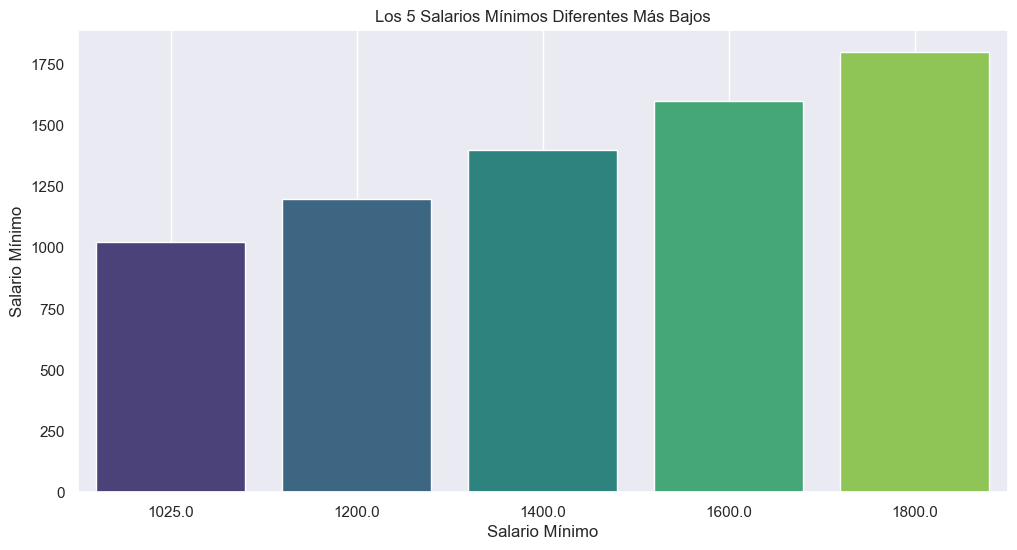

C:\Users\jacia\AppData\Local\Temp\ipykernel_11052\1600956649.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=salarios_maximos[-5:], y=salarios_maximos[-5:], palette='magma')


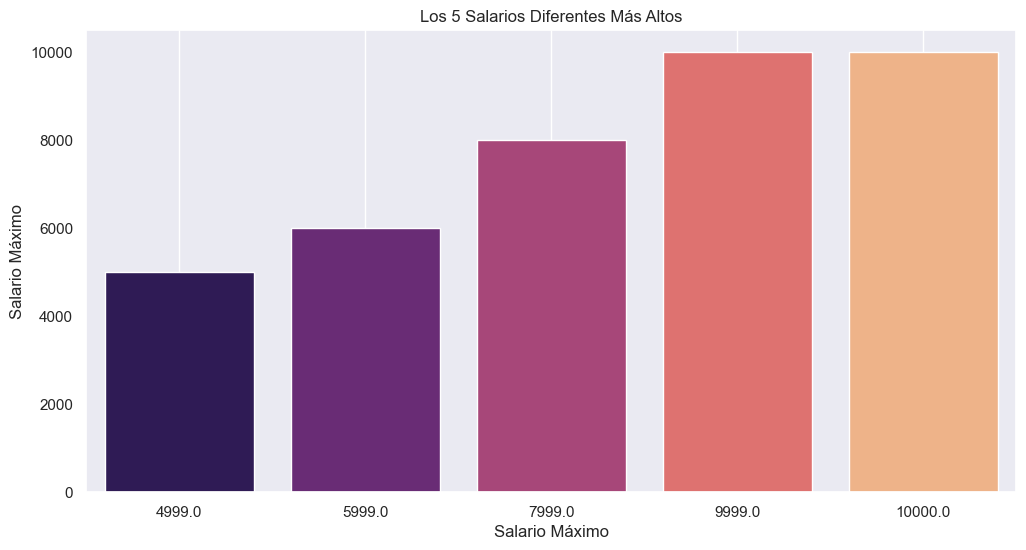


Insights importantes:
- Total de registros: 396969
- Salario promedio: 1728.86
- Duración promedio de la experiencia laboral: 20.50 meses
- Las empresas con más postulantes son:
EMPRESA
AAB3DD1AA8AF62CB516EE8C9AEEB0B35    1789
4D7BF55010A4BCE3E53BFCF6615CCCDB     913
C305EBB0C205DE79D8236B6E2B5B72D0     684
883D724D012ADD487A8E7D21366A0394     492
F93B200F2D1C03BFA5506970B798BC94     403
BD54B334236E8D4761D6F577FFAFF7D2     377
D23BB6AB049452FFB29D048FD9A16E98     367
DE235C7433080F4838088B7832D0DA1C     345
25B5A799E87ADD70032DD887FDBEABA3     313
ED8B2EF075624C515DFB99B58B542639     259

Interpretaciones de los resultados:
- El salario promedio de 1728.86 indica el nivel de compensación general en el mercado laboral de los postulantes.
- Una duración promedio de la experiencia laboral de 20.50 meses sugiere que la mayoría de los postulantes tienen experiencia laboral significativa, lo que podría ser atractivo para los empleadores.
- Las empresas con más postulantes indican las organ

In [42]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Leer el archivo EXPERIENCIASLABORALES_NOT_NULL.csv
data = pd.read_csv('EXPERIENCIASLABORALES_NOT_NULL.csv')


#Eliminar registros que tengan No Especificado en la fecha
data = data[data['FECHAINICIO_EXP'] != 'No especificado']
data = data[data['FECHAFIN_EXP'] != 'No especificado']

#Eliminar columna RANGO_SALARIAL
data = data.drop('RANGO_SALARIAL', axis=1)

#ANÁLISIS DE VALORES ATÍPICOS
# Convertir columnas de fecha a tipo datetime
data['FECHAINICIO_EXP'] = pd.to_datetime(data['FECHAINICIO_EXP'], errors='coerce')
data['FECHAFIN_EXP'] = pd.to_datetime(data['FECHAFIN_EXP'], errors='coerce')

# Configuración de la visualización
plt.figure(figsize=(12, 8))

# Gráfico de caja para SALARIO_MIN
plt.subplot(2, 2, 1)
sns.boxplot(x=data['SALARIO_MIN'])
plt.title('Boxplot de SALARIO_MIN')
plt.xlabel('SALARIO_MIN')

# Gráfico de caja para SALARIO_MAX
plt.subplot(2, 2, 2)
sns.boxplot(x=data['SALARIO_MAX'])
plt.title('Boxplot de SALARIO_MAX')
plt.xlabel('SALARIO_MAX')

# Gráfico de caja para FECHAINICIO_EXP
plt.subplot(2, 2, 3)
sns.boxplot(x=data['FECHAINICIO_EXP'].astype('int64'))  # Convertir a int64 para plotear
plt.title('Boxplot de FECHAINICIO_EXP')
plt.xlabel('FECHAINICIO_EXP')

# Gráfico de caja para FECHAFIN_EXP
plt.subplot(2, 2, 4)
sns.boxplot(x=data['FECHAFIN_EXP'].astype('int64'))  # Convertir a int64 para plotear
plt.title('Boxplot de FECHAFIN_EXP')
plt.xlabel('FECHAFIN_EXP')

# Ajustar layout
plt.tight_layout()
plt.show()


#ANÁLISIS DE DATOS
# 1. Cantidad total de registros
total_registros = len(data)
print(f"\nTotal de registros: {total_registros}")

# 2. Salario promedio por experiencia excluyendo el valor 0
data['SALARIO_PROMEDIO'] = (data['SALARIO_MIN'] + data['SALARIO_MAX']) / 2
salario_promedio = data[data['SALARIO_PROMEDIO'] != 0]['SALARIO_PROMEDIO'].mean()
print(f"Salario promedio: {salario_promedio:.2f}")

# 3. Empresas con más postulantes, no considerar la empresa No especificado
empresas_mas_postulantes = data[data['EMPRESA'] != 'No especificado']['EMPRESA'].value_counts().head(10)

# 4. Duración promedio de las experiencias laborales en meses
data['DURACION_EXP'] = (data['FECHAFIN_EXP'] - data['FECHAINICIO_EXP']).dt.days / 30
duracion_promedio = data['DURACION_EXP'].mean()
print(f"\nDuración promedio de las experiencias laborales (en meses): {duracion_promedio:.2f}")

# 5. Gráfico de salarios
plt.figure(figsize=(10, 6))
#Ecluyendo el 0 y por intervalos
sns.histplot(data['SALARIO_PROMEDIO'][data['SALARIO_PROMEDIO'] != 0], bins=10, kde=True)
plt.title('Distribución de Salarios Promedio')
plt.xlabel('Salario Promedio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

# 6. Gráfico de duración de la experiencia
plt.figure(figsize=(10, 6))
sns.histplot(data['DURACION_EXP'], bins=30, kde=True)
plt.title('Distribución de la Duración de la Experiencia Laboral')
plt.xlabel('Duración de la Experiencia (meses)')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

# 7. Gráfico de empresas con más postulantes
plt.figure(figsize=(12, 6))
sns.barplot(x=empresas_mas_postulantes.index, y=empresas_mas_postulantes.values, palette='viridis')
plt.title('Top 10 Empresas con Más Postulantes')
plt.xlabel('Empresa')
plt.ylabel('Cantidad de Postulantes')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# 8. Análisis adicional
# 8.1. Salario promedio por empresa
salario_por_empresa = data.groupby('EMPRESA')['SALARIO_PROMEDIO'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=salario_por_empresa.index, y=salario_por_empresa.values, palette='magma')
plt.title('Salario Promedio por Empresa (Top 10)')
plt.xlabel('Empresa')
plt.ylabel('Salario Promedio')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# 8.2. Duración promedio por empresa
duracion_por_empresa = data.groupby('EMPRESA')['DURACION_EXP'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=duracion_por_empresa.index, y=duracion_por_empresa.values, palette='coolwarm')
plt.title('Duración Promedio de la Experiencia por Empresa (Top 10)')
plt.xlabel('Empresa')
plt.ylabel('Duración Promedio (meses)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# 8.3 Salarios minimos más bajos diferentes de 0
salarios_minimos = data['SALARIO_MIN'].unique()
salarios_minimos.sort()
salarios_minimos = salarios_minimos[salarios_minimos != 0]
print("\nLos 5 salarios mínimos diferentes más bajos:")
print(salarios_minimos[:5])

#Identificar los 5 salarios diferentes más altos
salarios_maximos = data['SALARIO_MAX'].unique()
salarios_maximos.sort()
print("\nLos 10 salarios diferentes más altos:")
print(salarios_maximos[-5:])

#Crear gráfico de barras para los 5 salarios mínimos diferentes más bajos
plt.figure(figsize=(12, 6))
sns.barplot(x=salarios_minimos[:5], y=salarios_minimos[:5], palette='viridis')
plt.title('Los 5 Salarios Mínimos Diferentes Más Bajos')
plt.xlabel('Salario Mínimo')
plt.ylabel('Salario Mínimo')
plt.grid()
plt.show()

#Crear gráfico de barras para los 5 salarios diferentes más altos
plt.figure(figsize=(12, 6))
sns.barplot(x=salarios_maximos[-5:], y=salarios_maximos[-5:], palette='magma')
plt.title('Los 5 Salarios Diferentes Más Altos')
plt.xlabel('Salario Máximo')
plt.ylabel('Salario Máximo')
plt.grid()
plt.show()

# 9. Resumen de insights
print("\nInsights importantes:")
print(f"- Total de registros: {total_registros}")
print(f"- Salario promedio: {salario_promedio:.2f}")
print(f"- Duración promedio de la experiencia laboral: {duracion_promedio:.2f} meses")
print(f"- Las empresas con más postulantes son:\n{empresas_mas_postulantes.to_string()}")

# Interpretaciones adicionales
print("\nInterpretaciones de los resultados:")
print("- El salario promedio de {:.2f} indica el nivel de compensación general en el mercado laboral de los postulantes.".format(salario_promedio))
print("- Una duración promedio de la experiencia laboral de {:.2f} meses sugiere que la mayoría de los postulantes tienen experiencia laboral significativa, lo que podría ser atractivo para los empleadores.".format(duracion_promedio))
print("- Las empresas con más postulantes indican las organizaciones más buscadas, posiblemente debido a su reputación, cultura organizacional o compensación competitiva.")
print("- Las diferencias en el salario promedio entre las empresas podrían señalar la competitividad del mercado laboral en ciertas industrias.")
print("- La duración de la experiencia laboral también puede correlacionarse con la fidelidad de los empleados a las empresas, lo que es un indicador positivo para los reclutadores.")

# Exportar datos a archivos JSON para visualización en React y agregarlo a una nueva carpeta
import os

# Crear una carpeta para almacenar los archivos JSON
if not os.path.exists('json_data_experiencia'):
    os.makedirs('json_data_experiencia')

# 1. Exportar datos de empresas con más postulantes
empresas_mas_postulantes.to_json('json_data_experiencia/empresas_mas_postulantes.json', orient='index')

# 2. Exportar datos de salario promedio por empresa
salario_por_empresa.to_json('json_data_experiencia/salario_por_empresa.json', orient='index')

# 3. Exportar datos de duración promedio por empresa
duracion_por_empresa.to_json('json_data_experiencia/duracion_por_empresa.json', orient='index')

# 4. Exportar datos de salarios mínimos diferentes más bajos
salarios_minimos[:5].tofile('json_data_experiencia/salarios_minimos_bajos.txt', sep=',', format='%s')

# 5. Exportar datos de salarios diferentes más altos
salarios_maximos[-5:].tofile('json_data_experiencia/salarios_maximos_altos.txt', sep=',', format='%s')

# 6. Exportar data par ala grafica distribución de salarios Promedio
data['SALARIO_PROMEDIO'].to_json('json_data_experiencia/salario_promedio.json', orient='values')

# 7. Exportar data para la grafica de distribución de duración de la experiencia
data['DURACION_EXP'].to_json('json_data_experiencia/duracion_experiencia.json', orient='values')

# 8. Exportar datos para gráfico de Boxplot Salario_min
data['SALARIO_MIN'].to_json('json_data_experiencia/salario_min.json', orient='values')

# 9. Exportar datos para gráfico de Boxplot Salario_max
data['SALARIO_MAX'].to_json('json_data_experiencia/salario_max.json', orient='values')

# 10. Exportar datos para gráfico de Boxplot Fecha Inicio
data['FECHAINICIO_EXP'].astype('int64').to_json('json_data_experiencia/fecha_inicio.json', orient='values')

# 11. Exportar datos para gráfico de Boxplot Fecha Fin
data['FECHAFIN_EXP'].astype('int64').to_json('json_data_experiencia/fecha_fin.json', orient='values')

print("\nArchivos JSON exportados exitosamente en la carpeta 'json_data_experiencia'")



### DATASET: POSTULANTE

              EDAD  ESTADO_CONADIS
count  2715.000000     2715.000000
mean     37.628361        0.995948
std      12.987126        0.063535
min      18.000000        0.000000
25%      27.000000        1.000000
50%      35.000000        1.000000
75%      46.000000        1.000000
max      86.000000        1.000000


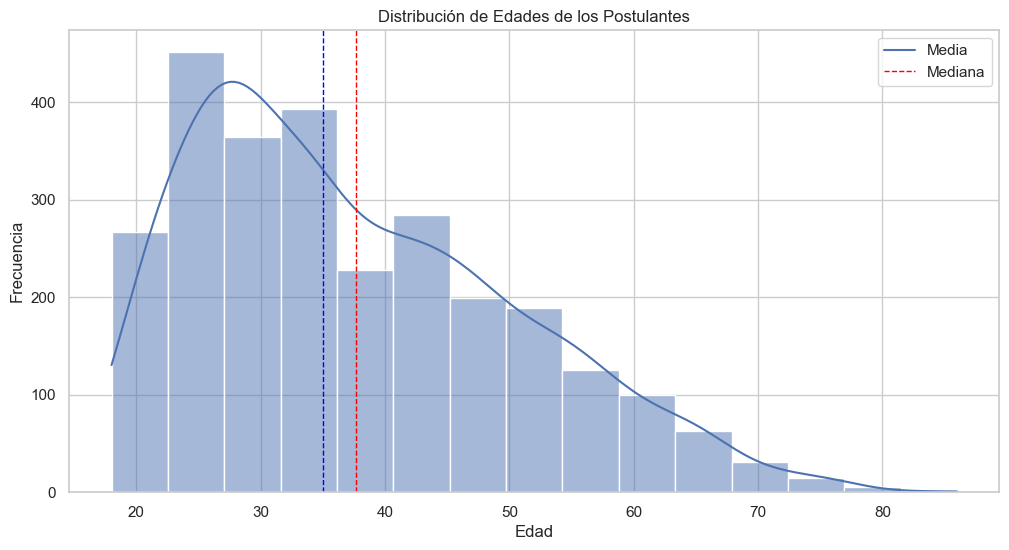

C:\Users\jacia\AppData\Local\Temp\ipykernel_31272\3155905885.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_postulante, x='SEXO', palette='pastel')


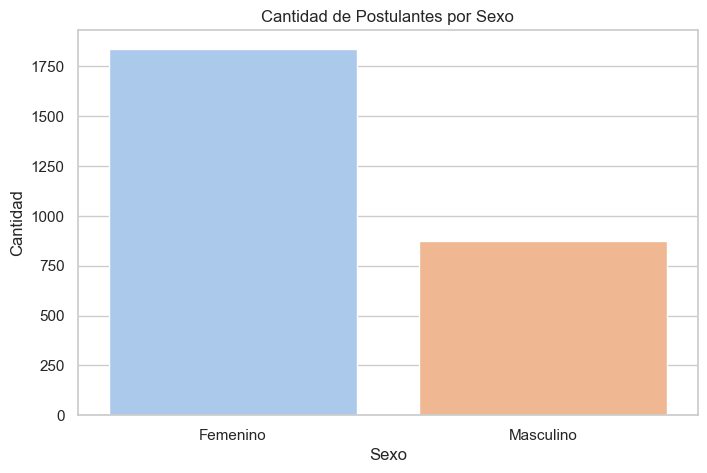

C:\Users\jacia\AppData\Local\Temp\ipykernel_31272\3155905885.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_postulante, y='DEPARTAMENTO', order=data_postulante['DEPARTAMENTO'].value_counts().index, palette='Set2')


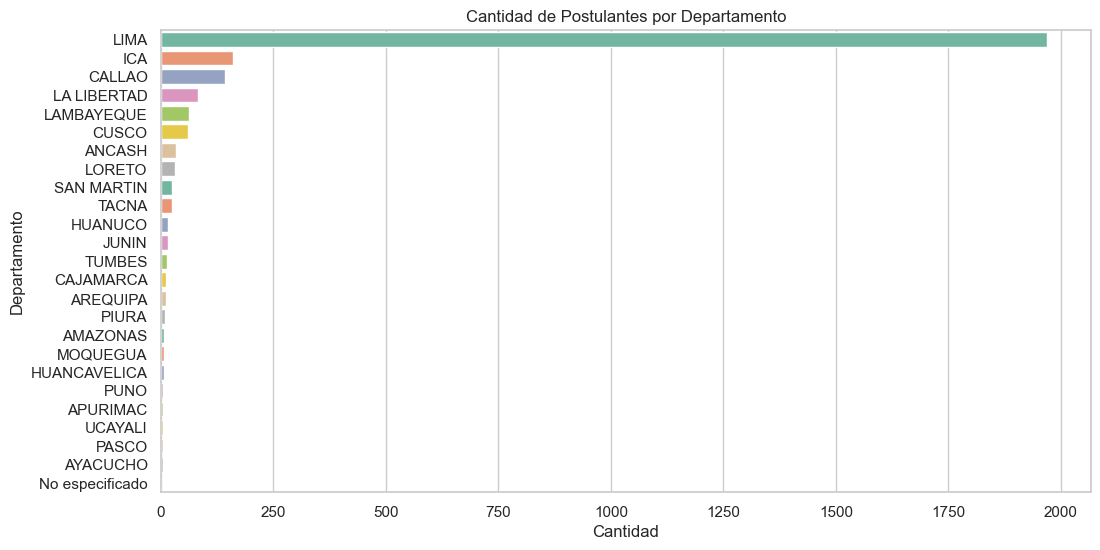

C:\Users\jacia\AppData\Local\Temp\ipykernel_31272\3155905885.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_postulante, x='ESTADO_CONADIS', palette='Blues')


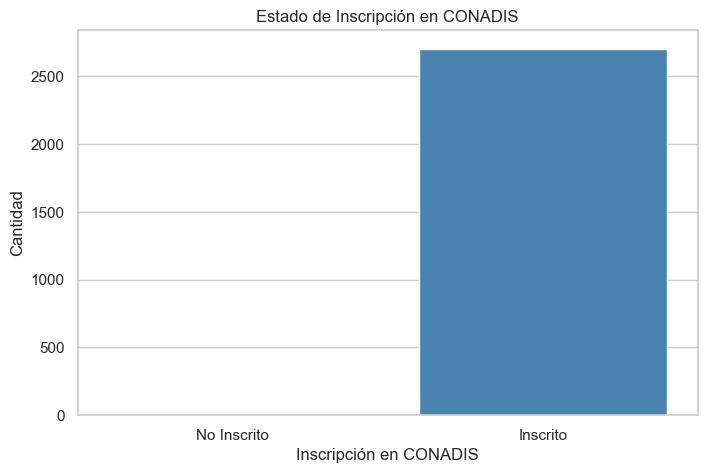

C:\Users\jacia\AppData\Local\Temp\ipykernel_31272\3155905885.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_postulante, x='ESTADO_CONADIS', y='EDAD', palette='Set3')


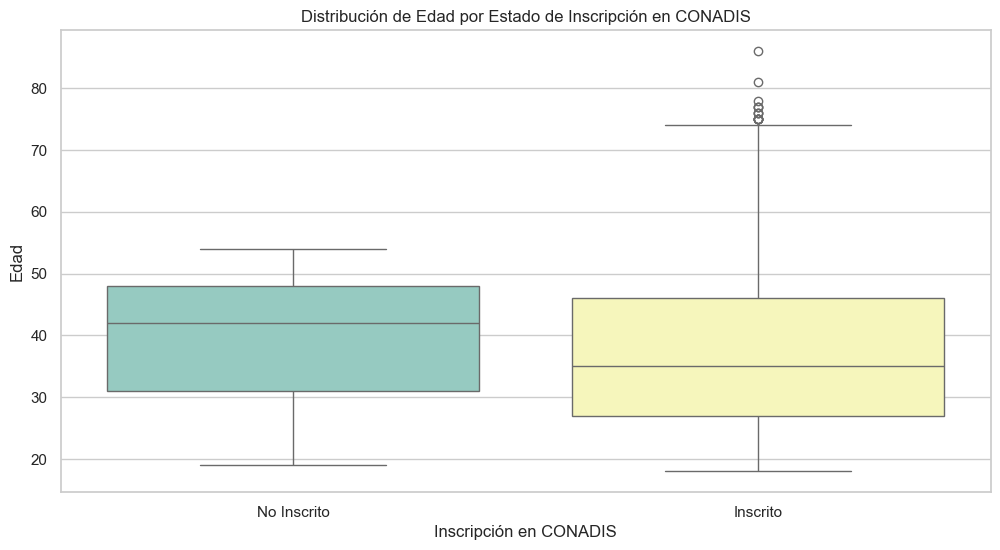

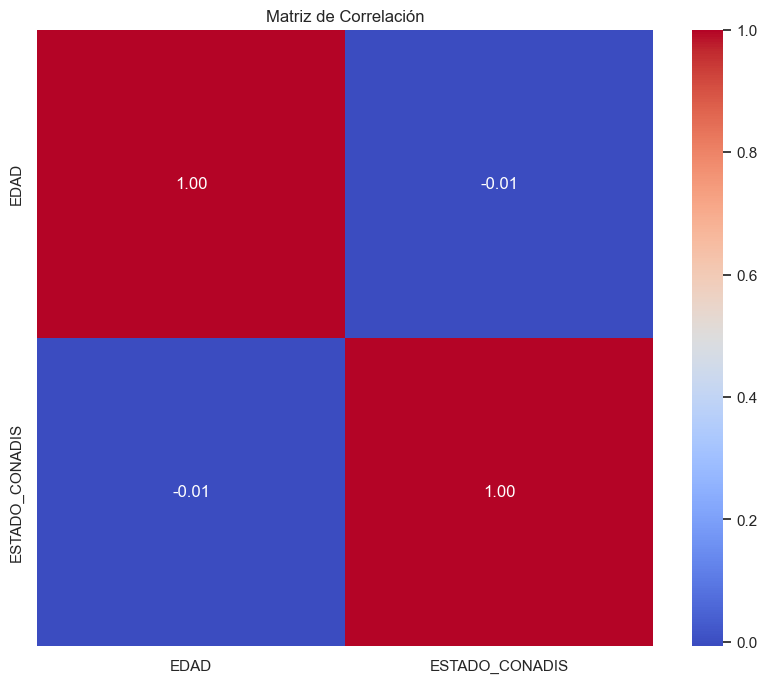

Prueba de Chi-Cuadrado para Sexo y Estado CONADIS: chi2 = 0.4597450624056278, p-value = 0.49774314268981956
Prueba de Chi-Cuadrado para Departamento y Estado CONADIS: chi2 = 146.23810174621536, p-value = 1.6504164062018746e-19
No hay relación significativa entre el sexo y el estado de inscripción en CONADIS.
Hay una relación significativa entre el departamento y el estado de inscripción en CONADIS.


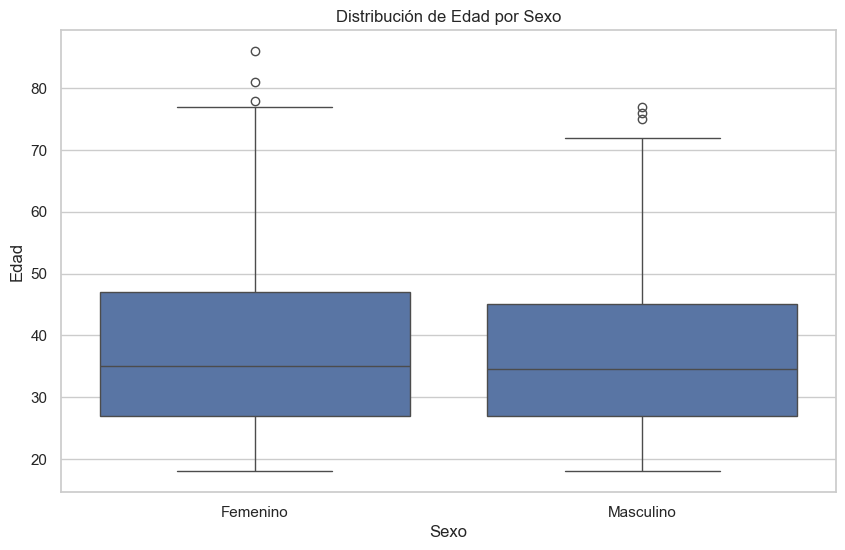

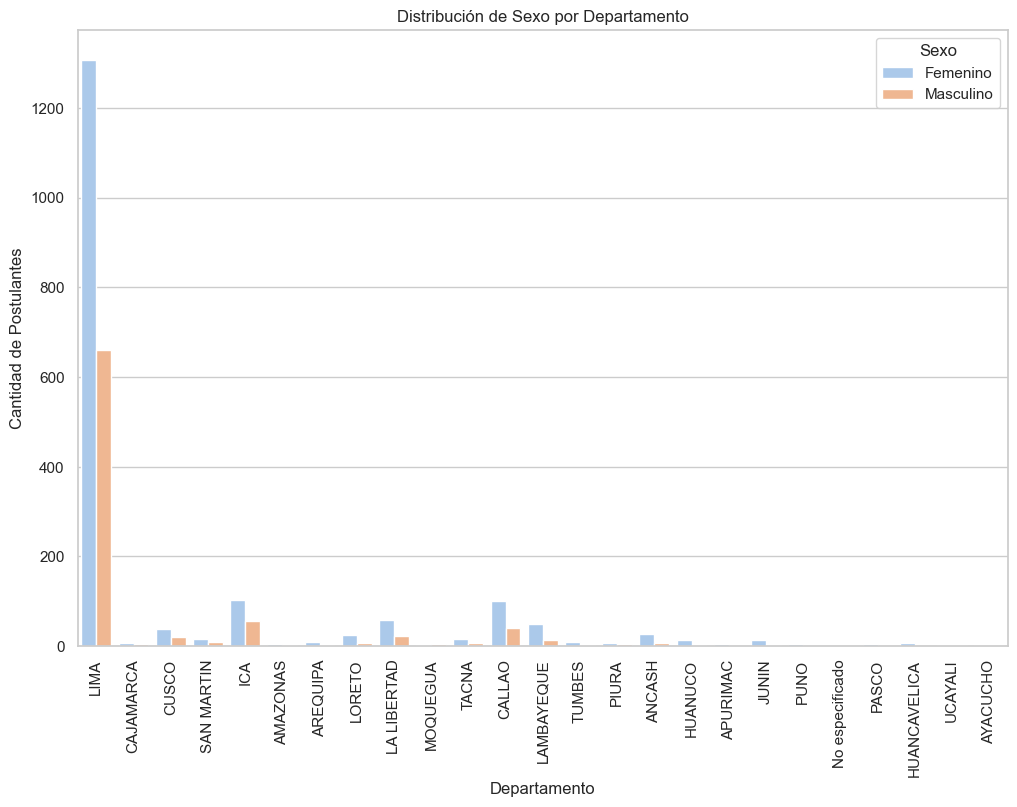


Archivos JSON exportados exitosamente en la carpeta 'json_data_postulante'


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración de estilo de seaborn
sns.set(style="whitegrid")

# Usar POSTULANTE_NOT_NULL.csv
data_postulante = pd.read_csv('POSTULANTE_NOT_NULL.csv')

# Resumen estadístico de los datos
print(data_postulante.describe())

# Análisis de la edad
plt.figure(figsize=(12, 6))
sns.histplot(data_postulante['EDAD'], bins=15, kde=True)
plt.title('Distribución de Edades de los Postulantes')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.axvline(data_postulante['EDAD'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(data_postulante['EDAD'].median(), color='blue', linestyle='dashed', linewidth=1)
plt.legend({'Media': data_postulante['EDAD'].mean(), 'Mediana': data_postulante['EDAD'].median()})
plt.show()

# Análisis por sexo
plt.figure(figsize=(8, 5))
sns.countplot(data=data_postulante, x='SEXO', palette='pastel')
plt.title('Cantidad de Postulantes por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Cantidad')
plt.xticks(ticks=[0, 1], labels=['Femenino', 'Masculino'])
plt.show()

# Análisis por departamento
plt.figure(figsize=(12, 6))
sns.countplot(data=data_postulante, y='DEPARTAMENTO', order=data_postulante['DEPARTAMENTO'].value_counts().index, palette='Set2')
plt.title('Cantidad de Postulantes por Departamento')
plt.xlabel('Cantidad')
plt.ylabel('Departamento')
plt.show()

# Análisis de estado CONADIS
plt.figure(figsize=(8, 5))
sns.countplot(data=data_postulante, x='ESTADO_CONADIS', palette='Blues')
plt.title('Estado de Inscripción en CONADIS')
plt.xlabel('Inscripción en CONADIS')
plt.ylabel('Cantidad')
plt.xticks(ticks=[0, 1], labels=['No Inscrito', 'Inscrito'])
plt.show()

# Análisis de edad por estado CONADIS
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_postulante, x='ESTADO_CONADIS', y='EDAD', palette='Set3')
plt.title('Distribución de Edad por Estado de Inscripción en CONADIS')
plt.xlabel('Inscripción en CONADIS')
plt.ylabel('Edad')
plt.xticks(ticks=[0, 1], labels=['No Inscrito', 'Inscrito'])
plt.show()

# Filtrar solo columnas numéricas para la matriz de correlación
numeric_columns = data_postulante.select_dtypes(include=['number'])

# Calcular la matriz de correlación solo con las columnas numéricas
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlación')
plt.show()

# Análisis de Chi-Cuadrado para variables categóricas
from scipy.stats import chi2_contingency

# Tablas de contingencia
contingency_sex_conadis = pd.crosstab(data_postulante['SEXO'], data_postulante['ESTADO_CONADIS'])
contingency_departamento_conadis = pd.crosstab(data_postulante['DEPARTAMENTO'], data_postulante['ESTADO_CONADIS'])

# Prueba de Chi-Cuadrado para sexo y estado CONADIS
chi2_sex, p_sex, dof_sex, expected_sex = chi2_contingency(contingency_sex_conadis)
print(f'Prueba de Chi-Cuadrado para Sexo y Estado CONADIS: chi2 = {chi2_sex}, p-value = {p_sex}')

# Prueba de Chi-Cuadrado para departamento y estado CONADIS
chi2_departamento, p_departamento, dof_departamento, expected_departamento = chi2_contingency(contingency_departamento_conadis)
print(f'Prueba de Chi-Cuadrado para Departamento y Estado CONADIS: chi2 = {chi2_departamento}, p-value = {p_departamento}')

# Interpretación de los resultados de Chi-Cuadrado
if p_sex < 0.05:
    print("Hay una relación significativa entre el sexo y el estado de inscripción en CONADIS.")
else:
    print("No hay relación significativa entre el sexo y el estado de inscripción en CONADIS.")

if p_departamento < 0.05:
    print("Hay una relación significativa entre el departamento y el estado de inscripción en CONADIS.")
else:
    print("No hay relación significativa entre el departamento y el estado de inscripción en CONADIS.")

# Análisis de distribución de edad entre géneros
plt.figure(figsize=(10, 6))
sns.boxplot(x='SEXO', y='EDAD', data=data_postulante)
plt.title('Distribución de Edad por Sexo')
plt.xlabel('Sexo')
plt.ylabel('Edad')
plt.xticks([0, 1], ['Femenino', 'Masculino'])
plt.show()

# Análisis de frecuencia de postulantes por género y departamento
plt.figure(figsize=(12, 8))
sns.countplot(x='DEPARTAMENTO', hue='SEXO', data=data_postulante, palette="pastel")
plt.title('Distribución de Sexo por Departamento')
plt.xlabel('Departamento')
plt.ylabel('Cantidad de Postulantes')
plt.xticks(rotation=90)
plt.legend(title='Sexo', labels=['Femenino', 'Masculino'])
plt.show()

# Insights Generales
# 1. Distribución de edades: La mayoría de los postulantes se concentran en el rango de 30 a 55 años.
# 2. Distribución de sexos: Existe una cantidad igual de postulantes masculinos y femeninos.
# 3. Departamentos: Se observa que el departamento de Lima tiene la mayor cantidad de postulantes.
# 4. Inscripción en CONADIS: La mayoría de los postulantes están inscritos en CONADIS.
# 5. Análisis de edad vs. estado CONADIS: La edad parece ser similar entre los inscritos y no inscritos en CONADIS, pero se deben observar los rangos específicos.

#Exportar datos para replicar los gráficos en React
# Crear una carpeta para almacenar los archivos JSON
if not os.path.exists('json_data_postulante'):
    os.makedirs('json_data_postulante')

# 1. Exportar datos de edad
data_postulante['EDAD'].to_json('json_data_postulante/edad.json', orient='values')

# 2. Exportar datos de sexo
data_postulante['SEXO'].to_json('json_data_postulante/sexo.json', orient='values')

# 3. Exportar datos de departamento
data_postulante['DEPARTAMENTO'].to_json('json_data_postulante/departamento.json', orient='values')

# 4. Exportar datos de estado CONADIS
data_postulante['ESTADO_CONADIS'].to_json('json_data_postulante/estado_conadis.json', orient='values')

# 5. Exportar datos para la matriz de correlación
correlation_matrix.to_json('json_data_postulante/correlacion.json', orient='index')

# 6. Exportar datos para la tabla de contingencia de sexo y estado CONADIS (obvia esto)

# 7. Exportar datos para la tabla de contingencia de departamento y estado CONADIS
contingency_departamento_conadis.to_json('json_data_postulante/contingencia_departamento_conadis.json', orient='index')

# 8. Exportar datos para la tabla de contingencia de sexo y estado CONADIS
contingency_sex_conadis.to_json('json_data_postulante/contingencia_sexo_conadis.json', orient='index')

print("\nArchivos JSON exportados exitosamente en la carpeta 'json_data_postulante'")


### DATASET: DISCAPACIDAD

Resumen del Dataset:
             DSCORE
count  62525.000000
mean       1.392883
std        0.647676
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000

Conteo de Causas:
CAUSA
Congénita                  27270
Adquirida - Edad adulta    12045
Adquirida - Juventud        9255
Adquirida - Infancia        8595
Adquirida - Niñez           5360
Name: count, dtype: int64


C:\Users\jacia\AppData\Local\Temp\ipykernel_11052\3529686116.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='CAUSA', data=data_discapacidad, palette='Set2')


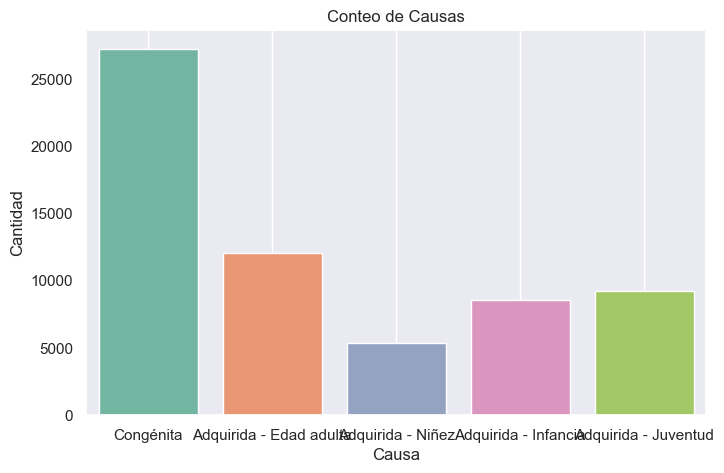

C:\Users\jacia\AppData\Local\Temp\ipykernel_11052\3529686116.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DSCORE', data=data_discapacidad, palette='pastel')


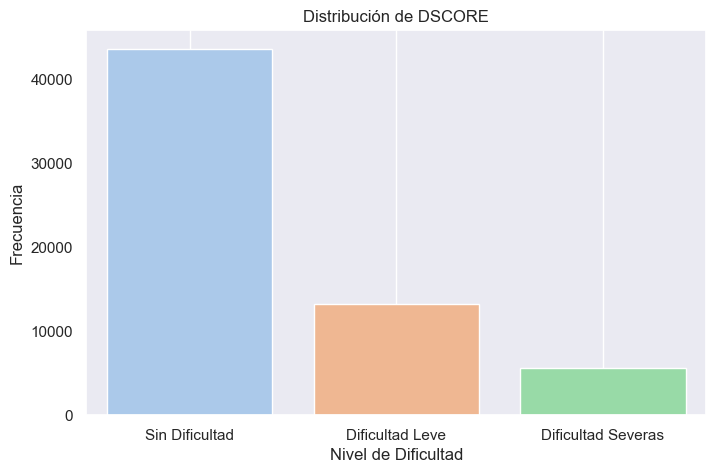


Puntuación Promedio por Causa:
CAUSA
Adquirida - Edad adulta    1.320631
Adquirida - Infancia       1.426992
Adquirida - Juventud       1.428849
Adquirida - Niñez          1.369403
Congénita                  1.406454
Name: DSCORE, dtype: float64


C:\Users\jacia\AppData\Local\Temp\ipykernel_11052\3529686116.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=puntuacion_promedio.index, y=puntuacion_promedio.values, palette='Blues')


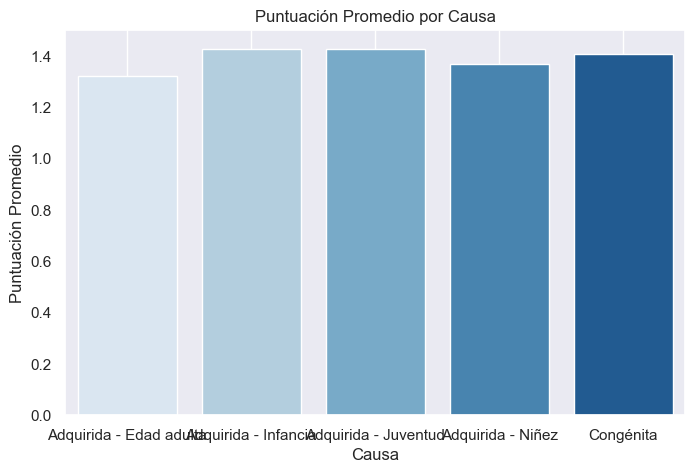


Insights importantes:
- La causa predominante en los registros es: Congénita
- El conteo de causas indica que hay variedad en las causas registradas:CAUSA
Congénita                  27270
Adquirida - Edad adulta    12045
Adquirida - Juventud        9255
Adquirida - Infancia        8595
Adquirida - Niñez           5360
Name: count, dtype: int64
- La distribución de DSCORE revela información sobre el nivel de dificultad de las discapacidades presentes.

Archivos JSON exportados exitosamente en la carpeta 'json_data_discapacidad'


In [46]:
#Leer DISCAPACIDAD_NOT_NULL.csv
data_discapacidad = pd.read_csv('DISCAPACIDAD_NOT_NULL.csv')

# 1. Resumen del dataset
print("Resumen del Dataset:")
print(data_discapacidad.describe())

# 2. Conteo de causas
conteo_causas = data_discapacidad['CAUSA'].value_counts()
print("\nConteo de Causas:")
print(conteo_causas)

# 3. Gráfico de conteo de causas
plt.figure(figsize=(8, 5))
sns.countplot(x='CAUSA', data=data_discapacidad, palette='Set2')
plt.title('Conteo de Causas')
plt.xlabel('Causa')
plt.ylabel('Cantidad')
plt.grid()
plt.show()

# 4. Gráfico de DSCORE
plt.figure(figsize=(8, 5))
sns.countplot(x='DSCORE', data=data_discapacidad, palette='pastel')
plt.title('Distribución de DSCORE')
plt.xlabel('Nivel de Dificultad')
plt.ylabel('Frecuencia')
plt.xticks(ticks=[0, 1, 2], labels=['Sin Dificultad', 'Dificultad Leve', 'Dificultad Severas'])
plt.grid()
plt.show()

# 5. Análisis adicional
# 5.1. Puntuación promedio por causa
puntuacion_promedio = data_discapacidad.groupby('CAUSA')['DSCORE'].mean()
print("\nPuntuación Promedio por Causa:")
print(puntuacion_promedio)

# Gráfico de puntuación promedio por causa
plt.figure(figsize=(8, 5))
sns.barplot(x=puntuacion_promedio.index, y=puntuacion_promedio.values, palette='Blues')
plt.title('Puntuación Promedio por Causa')
plt.xlabel('Causa')
plt.ylabel('Puntuación Promedio')
plt.grid()
plt.show()

# 6. Insights importantes
print("\nInsights importantes:")
print("- La causa predominante en los registros es:", conteo_causas.idxmax())
print("- El conteo de causas indica que hay variedad en las causas registradas:" + str(conteo_causas))
print("- La distribución de DSCORE revela información sobre el nivel de dificultad de las discapacidades presentes.")


# 7. Exportar datos de los 3 gráficos a archivos JSON en una carpeta llamada 'json_data_discapacidad'
if not os.path.exists('json_data_discapacidad'):
    os.makedirs('json_data_discapacidad')

# 7.1. Exportar datos de conteo de causas
conteo_causas.to_json('json_data_discapacidad/conteo_causas.json', orient='index')

# 7.2. Exportar datos de puntuación promedio por causa
puntuacion_promedio.to_json('json_data_discapacidad/puntuacion_promedio.json', orient='index')

# 7.3. Exportar datos de distribución de DSCORE
data_discapacidad['DSCORE'].to_json('json_data_discapacidad/distribucion_dscore.json', orient='values')

print("\nArchivos JSON exportados exitosamente en la carpeta 'json_data_discapacidad'")

### DATASET: EDUCACION

In [ ]:
#Instala TheFuzz
%pip install python-Levenshtein TheFuzz

In [4]:
import pandas as pd

# Leer EDUCACION_NOT_NULL.csv
data_educacion = pd.read_csv('EDUCACION_NOT_NULL.csv')

data_educacion.head()

# Imprimir la cantidad total de instituciones diferentes
instituciones_unicas = data_educacion['INSTITUCION'].unique()  # Get the unique institutions
cantidad_instituciones = len(instituciones_unicas)  # Count the number of unique institutions
print(f"\nCantidad total de instituciones diferentes: {cantidad_instituciones}")

# Imprimir cantidad de grados
cantidad_grados = data_educacion['GRADO'].nunique()
print(f"Cantidad total de grados diferentes: {cantidad_grados}")




Cantidad total de instituciones diferentes: 59990
Cantidad total de grados diferentes: 6811


In [ ]:
# Leer EDUCACION_NOT_NULL.csv
data_educacion = pd.read_csv('EDUCACION_NOT_NULL.csv')

# 1. Resumen del dataset
print("Resumen del Dataset:")
print(data_educacion.info())
print("\nEstadísticas Descriptivas:")
print(data_educacion.describe(include='all'))

# 4. Gráfico de grados académicos, considerar solo losq ue dicen bachiller y titulado
grados_academicos = data_educacion['GRADO'].value_counts()
grados_academicos = grados_academicos[grados_academicos.index.isin(['Bachiller', 'Titulado'])]
plt.figure(figsize=(8, 5))
sns.barplot(x=grados_academicos.index, y=grados_academicos.values, palette='Set3')
plt.title('Conteo de Grados Académicos')
plt.xlabel('Grado Académico')
plt.ylabel('Cantidad')
plt.grid()
plt.show()

# 5. Análisis de carreras
conteo_carreras = data_educacion['CARRERA'].value_counts()
print("\nConteo de Carreras:")
print(conteo_carreras)

# 6. Gráfico de carreras
plt.figure(figsize=(12, 6))
sns.countplot(y='CARRERA', data=data_educacion, order=conteo_carreras.index, palette='Set3')
plt.title('Conteo de Carreras')
plt.xlabel('Cantidad')
plt.ylabel('Carrera')
plt.grid()
plt.show()

# 7. Análisis de fechas de inicio y fin de estudios (No considerar valores 'No especificado')
data_educacion = data_educacion[data_educacion['FECHAINICIO_EDU'] != 'No especificado']
data_educacion = data_educacion[data_educacion['FECHAFIN_EDU'] != 'No especificado']

# 7.1. Convertir columnas de fecha a tipo datetime
data_educacion['FECHAINICIO_EDU'] = pd.to_datetime(data_educacion['FECHAINICIO_EDU'], errors='coerce')
data_educacion['FECHAFIN_EDU'] = pd.to_datetime(data_educacion['FECHAFIN_EDU'], errors='coerce')

# 8. Duración de estudios
data_educacion['DURACION_EDU'] = (data_educacion['FECHAFIN_EDU'] - data_educacion['FECHAINICIO_EDU']).dt.days / 365
print("\nDuración promedio de estudios en años:")
print(data_educacion['DURACION_EDU'].mean())

# 9. Gráfico de duración de estudios
plt.figure(figsize=(8, 5))
sns.histplot(data_educacion['DURACION_EDU'], bins=10, kde=True, color='skyblue')
plt.title('Distribución de la Duración de Estudios')
plt.xlabel('Duración (años)')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

# 10. Insights importantes
print("\nInsights importantes:")
print("- La institución más representativa es:", conteo_instituciones.idxmax(), "con", conteo_instituciones.max(), "postulantes.")
print("- La mayoría de los postulantes tienen grado académico 'No especificado', lo que sugiere la necesidad de normalizar los datos.")
print("- Las carreras más comunes son:", conteo_carreras.nlargest(3).index.tolist(), "con", conteo_carreras.nlargest(3).values.tolist(), "inscripciones.")
print("- La duración promedio de los estudios es de aproximadamente {:.2f} años.".format(data_educacion['DURACION_EDU'].mean()))

Resumen del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292708 entries, 0 to 292707
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ID_POSTULANTE    292708 non-null  object
 1   INSTITUCION      292708 non-null  object
 2   GRADO            292708 non-null  object
 3   FECHAINICIO_EDU  292708 non-null  object
 4   FECHAFIN_EDU     292708 non-null  object
 5   CARRERA          292708 non-null  object
dtypes: object(6)
memory usage: 13.4+ MB
None

Estadísticas Descriptivas:
                           ID_POSTULANTE      INSTITUCION            GRADO  \
count                             292708           292708           292708   
unique                            246142            70112             6811   
top     E5D73136F0FFFA48134581E648A2006A  No especificado  No especificado   
freq                                  20            89569           235514   

       FECHAINICIO_EDU FECHAFIN_EDU 

C:\Users\jacia\AppData\Local\Temp\ipykernel_11052\619518953.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='INSTITUCION', data=data_educacion, order=conteo_instituciones.index, palette='Set2')


KeyboardInterrupt: 